In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# define key directories
scratch = '/scratch/aew492'

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from astropy.table import Table
import gaiaxpy
import pandas as pd
import os
import sys

#### GOAL:
Plot some Gaia QSO BP/RP spectra.

#### GaiaXPY
Documentation: https://gaiaxpy.readthedocs.io/en/latest/usage.html

Can take in a list of source IDs:

> Lists are accepted only by calibrate, convert, and generate.
These lists have to correspond to a list of source IDs.
Both lists of strings and lists of long are accepted.
When a list is passed to one of the tools, the function will internally request the required data for the given sources from the Gaia archive.
Passing Cosmos credentials (username and password) is optional.

#### Load Gaia DR3 passbands

In [4]:
pb_dir = '/scratch/aew492/quasars/GaiaEDR3_passbands_zeropoints_version2'
passband = np.loadtxt(os.path.join(pb_dir, 'passband.dat'))
lambdas, GPb, e_GPb, BPPb, e_BPPb, RPPb, e_RPPb = passband.T
# set all weird >1 values to zero
GPb[np.where(GPb>1)]=0
BPPb[np.where(BPPb>1)]=0
RPPb[np.where(RPPb>1)]=0

#### Functions

In [5]:
# plotting
def bpline(ax):
    ax.axvline(680, color='b', lw=0.5, alpha=0.2)
def rpline(ax):
    ax.axvline(640, color='r', lw=0.5, alpha=0.2)
    
def plot_BPPB(ax, norm=1, outline=True, lw=0.5, alpha=0.3, fillalpha=0.06):
    # line
    if outline:
        ax.plot(lambdas, norm*BPPb, color='b', alpha=alpha, lw=lw)
    # fill in 
    ax.fill_between(lambdas, norm*BPPb, color='b', alpha=fillalpha, label='BP passband')
    
def plot_RPPB(ax, norm=1, outline=True, lw=0.5, alpha=0.3, fillalpha=0.06):
    # line
    if outline:
        ax.plot(lambdas, norm*RPPb, color='r', alpha=alpha, lw=lw)
    # fill in 
    ax.fill_between(lambdas, norm*RPPb, color='r', alpha=fillalpha, label='RP passband')
    
def plot_GPB(ax, norm=1, alpha=0.06):
    ax.fill_between(lambdas, norm*GPb, color='g', alpha=fillalpha, label='G passband')

#### Get source IDs in QUaia

In [7]:
# load catalog
quaia_fn = os.path.join(scratch, 'quasars/catalogs/gaia_G20.0.fits')
data_quaia = Table.read(quaia_fn, format='fits')

In [8]:
data_quaia

ra,dec,redshift_qsoc,l,b,source_id,parallax,parallax_error,pmra,pmra_error,pmdec,pmdec_error,phot_g_mean_mag,phot_bp_mean_mag,phot_rp_mean_mag,redshift_qsoc_lower,redshift_qsoc_upper,zscore_qsoc,flags_qsoc,allwise_oid,w1mpro,w2mpro,g_rp,bp_g,bp_rp,g_w1,w1_w2,ebv,A_v,pm,redshift_spz,redshift_sdss
deg,deg,,deg,deg,,mas,mas,mas / yr,mas / yr,mas / yr,mas / yr,mag,mag,mag,,,,,,mag,mag,mag,mag,mag,mag,mag,,,mas / yr,,
float64,float64,float32,float64,float64,int64,float64,float32,float64,float32,float64,float32,float32,float32,float32,float32,float32,float32,int64,int64,float64,float64,float32,float32,float32,float64,float64,float32,float32,float64,float64,float64
45.18857525358218,0.28242442525431893,1.7364681,176.85154355262011,-48.5708559360798,10892037246720,0.0016301676623204295,0.24633229,-0.09803741741546984,0.257395,-0.12058003593273806,0.22310686,18.78724,19.080688,18.240915,1.7260774,1.7468984,0.99530387,0,386619386,15.307,13.849,0.5463238,0.2934494,0.8397732,3.480239074707031,1.4580000000000002,0.111800425,0.3465813,0.15540553490476286,1.709,1.742328
45.189480360571665,0.3591947400894022,1.5130492,176.76912910053676,-48.51684235773577,15839839588736,-0.33315377915341504,0.34581935,-0.31608849256513893,0.36059502,0.31878129338774636,0.3265819,18.888464,19.17128,18.50937,1.4994327,1.52674,0.9990658,1,387078327,15.327,13.961,0.37909317,0.28281593,0.6619091,3.5614639739990235,1.3659999999999997,0.108534,0.3364554,0.44892476891575755,1.4967610836029053,1.502309
44.79936522932521,0.30355729158111383,2.8528538,176.4176643816323,-48.83530904204095,22780506725760,0.08502490683954063,0.30630586,0.16823689536016173,0.36143935,0.495425361757415,0.269473,19.218422,19.48634,18.8145,2.8428693,2.8628643,0.9999098,16,386745193,15.978,15.087,0.40392113,0.26791763,0.67183876,3.2404219360351565,0.891,0.08300958,0.25732967,0.5232111830158942,2.857,2.863
45.07952191471843,0.43963647300547504,2.4766529,176.56632979004348,-48.539725067910446,29102698617216,-0.9814862972527233,0.6914001,0.13363335786463076,0.5716444,-0.19487478827025342,0.4993483,19.837416,20.162195,19.387741,2.4496243,2.5038934,0.9393421,26,387560320,16.041,14.762,0.4496746,0.3247795,0.7744541,3.7964156951904293,1.279,0.09385592,0.29095334,0.23629231353887198,1.4314243793487549,1.52988
44.99106740350177,0.5817285409510972,0.8034798,176.31953253315504,-48.5037567938138,35115652874752,0.5372017504179936,0.2974623,0.2025059976484399,0.22700854,-0.010802838455522882,0.22789434,18.863981,19.050497,18.467363,0.7938221,0.8131895,0.999966,0,388409516,14.518,13.365,0.3966179,0.18651581,0.5831337,4.3459812469482415,1.1530000000000005,0.09363897,0.2902808,0.20279393581240557,0.801863,0.820964
45.46314576335495,0.5223631031122293,2.5434763,176.87877917393385,-48.206673850472285,45389214407424,0.42691239586060614,0.37638897,0.029875722687410865,0.3681689,0.8799332192684758,0.3576673,19.413044,19.660446,19.003618,2.529237,2.557773,0.9967636,16,388055279,16.384,15.452,0.40942574,0.24740219,0.6568279,3.029043975830078,0.9320000000000004,0.10517552,0.32604408,0.8804402473639416,2.515,--
45.61545491514258,0.6311201802539346,1.0362633,176.9198990209358,-48.021551935865055,47931835055360,-0.14579918000018588,0.30917633,0.15813672856887673,0.37432006,0.13010117641026012,0.3599602,19.366932,19.695724,18.919903,1.0209733,1.051669,0.940988,17,388703244,15.081,13.894,0.4470291,0.32879257,0.7758217,4.285931915283204,1.1869999999999994,0.087977216,0.27272937,0.2047768078318446,1.060027,1.044975
45.1740573490588,0.5437712901320596,1.1151339,176.55321656589015,-48.3993514340487,54528905041920,0.477410189720131,0.23120196,0.01704548904689053,0.21791558,-0.018600249184391956,0.21231827,18.86396,19.043858,18.563738,1.0972285,1.1331921,0.93471116,11,388183093,14.814,13.432,0.3002224,0.17989731,0.4801197,4.049960266113281,1.3819999999999997,0.09589272,0.29726744,0.025229307691039374,1.094694,1.112908


In [9]:
# apparently there are only released spectra for G < 17.5, so filter this:
data_quaia_bright = data_quaia[data_quaia['phot_g_mean_mag']<17.5]

In [10]:
len(data_quaia_bright)

10815

In [13]:
# source ids: as a list to pass to gaiaxpy
source_ids = list(data_quaia_bright['source_id'])

In [14]:
# take the first ones to test
maxn = 500
source_ids_ = source_ids[:maxn]

In [15]:
spectra_df, sampling = gaiaxpy.calibrate(source_ids_)

In [16]:
spectra_df

,source_id,flux,flux_error
0,83116207389824,"[1.831280875858541e-17, 1.8564475430443224e-17...","[7.258763947890874e-18, 5.326796778051129e-18,..."
1,1233759421319424,"[3.798785069659016e-18, 3.404064607851355e-18,...","[3.533211134239206e-18, 2.5262181327808424e-18..."
2,4202269017377408,"[9.798378453289009e-18, 2.8233524226966e-18, 1...","[4.976922627959712e-18, 3.565591405703937e-18,..."
3,4309329666817408,"[7.732003018586312e-18, 5.597400922824512e-18,...","[3.763159845339314e-18, 2.9082702031719833e-18..."
4,7373909091680768,"[2.6061215780366247e-18, 8.741327912107547e-19...","[4.383441314725484e-18, 3.1484640951796632e-18..."
...,...,...,...
443,614776018112326656,"[1.0297132724425659e-17, 9.223990924055009e-18...","[4.842646198320025e-18, 3.475166201297682e-18,..."
444,614788387618936576,"[1.0078833813017e-17, 9.122072106154692e-18, 7...","[3.743839322222805e-18, 2.699505567638046e-18,..."
445,614898549234400640,"[3.6857280570953265e-17, 3.545839405689482e-17...","[1.0851531664665749e-17, 7.984515687810336e-18..."
446,614947340062874752,"[6.907372017278683e-18, 6.51011918566971e-18, ...","[3.401447521115533e-18, 2.4249932984825473e-18..."


In [17]:
# first few objects
nobj = 8
sids = []
fluxes = []
errs = []
for i in range(nobj):
    obj = spectra_df.iloc[i]
    sid, flux, err = obj
    sids.append(sid)
    fluxes.append(flux)
    errs.append(err)

In [18]:
# color map
cmap = matplotlib.colormaps['jet']
norm = matplotlib.colors.Normalize(vmin=0, vmax=nobj)

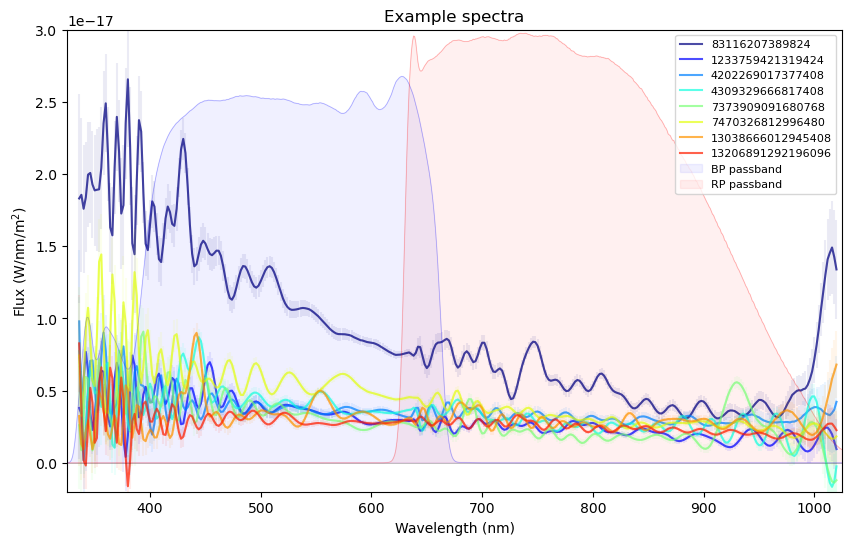

In [19]:
fig, ax = plt.subplots(figsize=(10,6))

for i, flux in enumerate(fluxes):
    ax.plot(sampling, flux, c=cmap(norm(i)), alpha=0.7, label=sids[i])
    ax.errorbar(sampling, flux, errs[i], c=cmap(norm(i)), alpha=0.08)
ax.axhline(0, c='k', lw=0.5, alpha=0.3)
plot_BPPB(ax, norm=4e-17)
plot_RPPB(ax, norm=4e-17)
ax.set_xlim((325,1025))
ax.set_ylim((-2e-18,3e-17))
ax.set_xlabel('Wavelength (nm)')
ax.set_ylabel('Flux (W/nm/m$^2$)')
ax.set_title(f'Example spectra')
ax.legend(loc=1, prop={'size':8})

In [20]:
sids

[83116207389824,
 1233759421319424,
 4202269017377408,
 4309329666817408,
 7373909091680768,
 7470326812996480,
 13038666012945408,
 13206891292196096]

In [21]:
# magnitudes for this source
sourcedata = data_quaia['source_id'==sid]
g = sourcedata['phot_g_mean_mag'] # in VEGAMAG
bp = sourcedata['phot_bp_mean_mag']
rp = sourcedata['phot_rp_mean_mag']
g, bp, rp

(18.78724, 19.080688, 18.240915)

In [22]:
# integrate over passband?